# Занятие 1. Введение в uplift-моделирование

## About the problem

Данные с соревнования https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html

В датасете содержится информация о 64 000 клиентов интернет-магазина, которые совершили покупку в последний раз в течение 12 месяцев перед e-mail рассылкой.

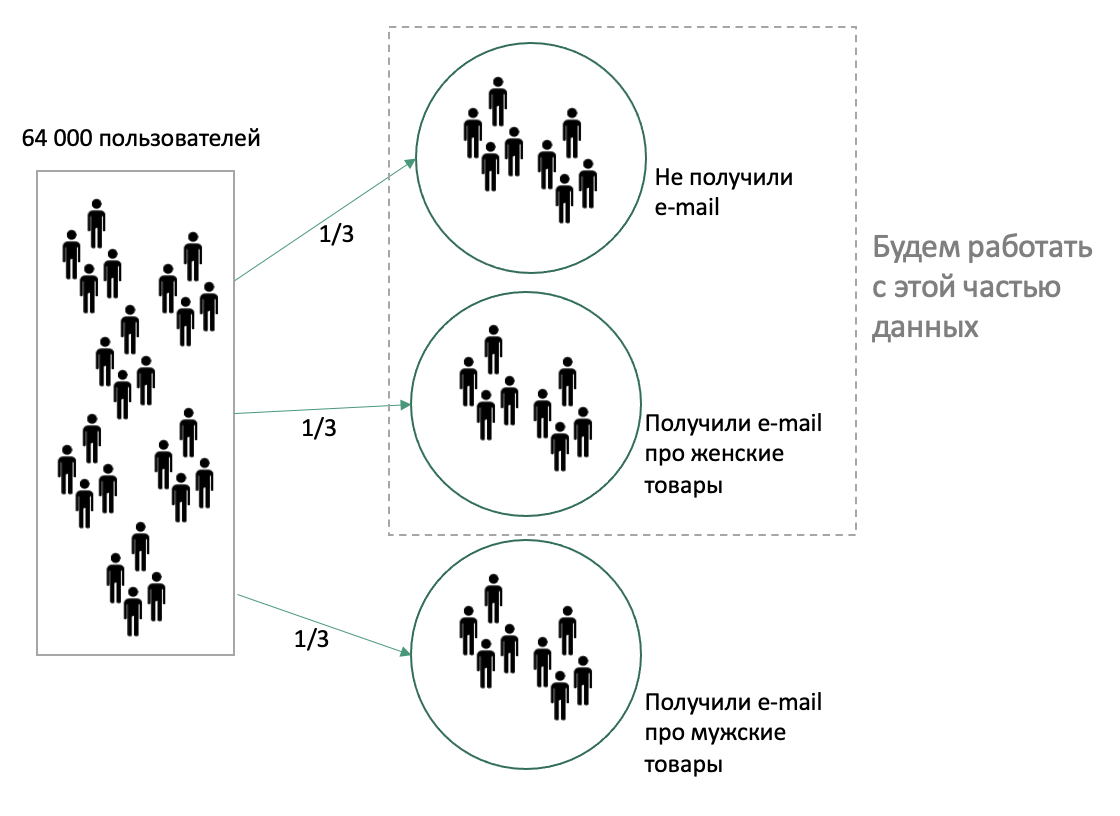

Описание клиента до рассылки

* Recency: Months since last purchase.
* History_Segment: Categorization of dollars spent in the past year.
* History: Actual dollar value spent in the past year.
* Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
* Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
* Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
* Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
* Channel: Describes the channels the customer purchased from in the past year.


В этой переменной указано то, к какой группе был отнесен клиент
* Segment ("Mens E-Mail", "Womens E-Mail", "No E-Mail")

Переменные, описывающие клиента в течение 2 недель после получения e-mail

* Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
* Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
* Spend: Actual dollars spent in the following two weeks.

## Head

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from typing import List

In [18]:
# !pip install scikit-uplift

In [12]:
import catboost as cb
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


In [20]:
import sklift.metrics
import sklift.viz

import pylift_utils

In [62]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [ ]:
# git clone https://github.com/uber/causalml.git
# cd causalml
# python setup.py build_ext --inplace
# python setup.py install

## Lib

In [21]:
def dict_coalesce(left_dict: dict, right_dict: dict) -> None:
    for key, value in right_dict.items():
        if key not in left_dict:
            left_dict[key] = value

class FunctionWrapper(object):
    def __init__(self, function, **params):
        self.params = params
        self.function = function

    def __call__(self, *args, **kwargs):
        dict_coalesce(kwargs, self.params)
        return self.function(*args, **kwargs)

In [22]:
def get_shap_values_(upmodel: pylift.TransformedOutcome):
    return upmodel.model.get_feature_importance(
        data=cb.Pool(
            data=upmodel.x_test,
            label=upmodel.transformed_y_test
        ),
        fstr_type='ShapValues'
    )

## Load'n'cook

Загрузим и преобразуем данные, с которыми будем работать

### load

In [24]:
data = pd.read_csv('data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [25]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [26]:
data['segment'].value_counts()

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: segment, dtype: int64

In [27]:
data_womens = data.query('segment in ("No E-Mail", "Womens E-Mail")')

In [28]:
data_womens['treatment'] = (data_womens['segment'] == "Womens E-Mail").astype('int32')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
data_womens.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,1
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0,1


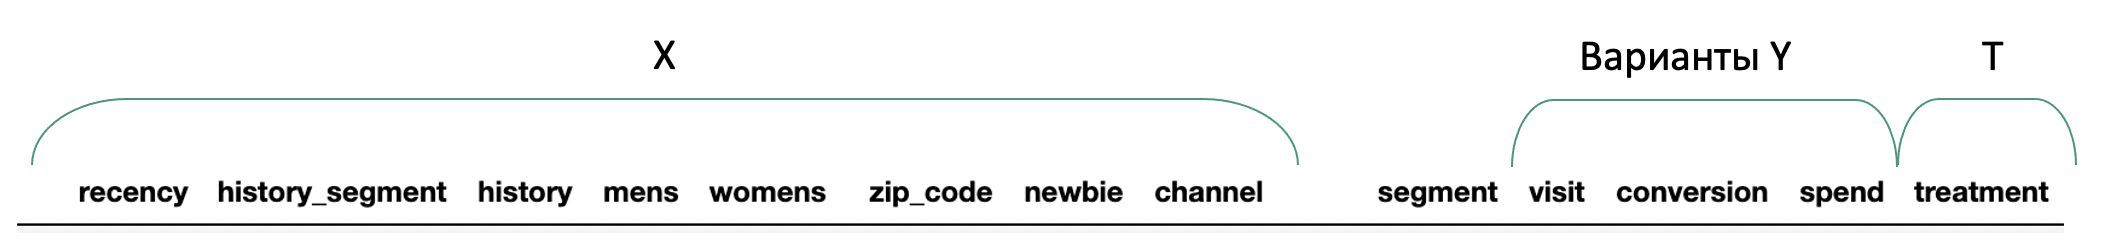

### explore

In [30]:
data_womens.shape

(42693, 13)

In [31]:
data_womens['zip_code'].value_counts()

Surburban    19275
Urban        17098
Rural         6320
Name: zip_code, dtype: int64

In [32]:
data_womens['channel'].value_counts()

Phone           18781
Web             18727
Multichannel     5185
Name: channel, dtype: int64

### transform

In [33]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [34]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [35]:
data_womens = transform_(data_womens)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [63]:
data_womens.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,zip_code_num,channel_num,history_segment__label,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,history_segment__label_1,history_segment__label_2,history_segment__label_3,history_segment__label_4,history_segment__label_5,history_segment__label_6,history_segment__label_7
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1,1,2,2,0,1,0,0,1,0,0,1,0,0,0,0,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,2,0,3,1,0,0,0,0,1,0,0,1,0,0,0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1,1,0,2,0,1,0,0,0,1,0,1,0,0,0,0,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0,1,1,2,2,0,1,0,0,1,0,0,1,0,0,0,0,0


### fit / validation split

In [37]:
fit_index, val_index = train_test_split(data_womens.index, test_size=0.5, random_state=148)

### column sets

In [38]:
data_womens.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend',
       'treatment', 'zip_code_num', 'channel_num', 'history_segment__label',
       'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment__label_1', 'history_segment__label_2',
       'history_segment__label_3', 'history_segment__label_4',
       'history_segment__label_5', 'history_segment__label_6',
       'history_segment__label_7'],
      dtype='object')

In [39]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

In [40]:
column_set_n2 = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web',
    'history_segment__label_1', 'history_segment__label_2',
    'history_segment__label_3', 'history_segment__label_4',
    'history_segment__label_5', 'history_segment__label_6',
    'history_segment__label_7'
]

## Modeling

### Transformed outcome

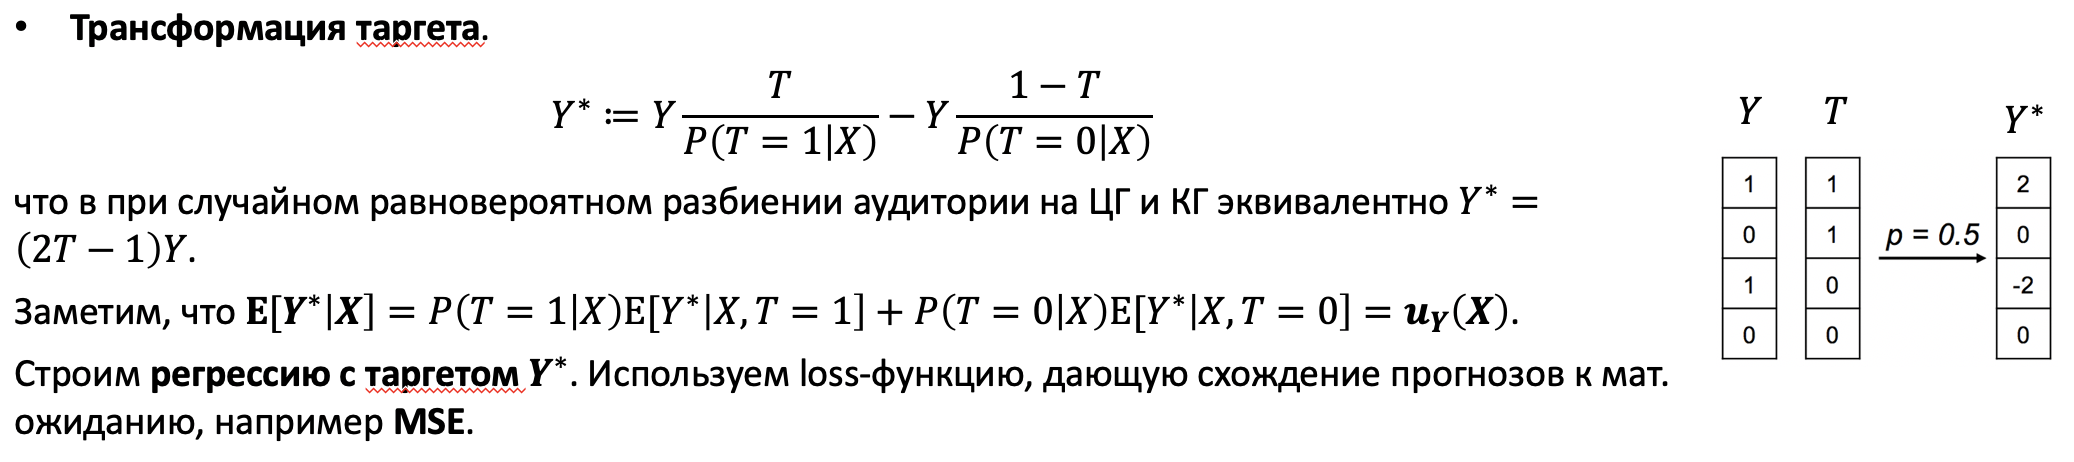

#### Построение модели

In [41]:
import pylift

In [42]:
upmodel_n0 = pylift.TransformedOutcome(
    data_womens.loc[fit_index, column_set_n1 + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=2
)

In [43]:
upmodel_n0.transformed_y_train

52917        -0.0
2950     1.993277
22171        -0.0
40261         0.0
29214         0.0
           ...   
51532         0.0
2082          0.0
56001   -2.006769
46130        -0.0
3082         -0.0
Name: TransformedOutcome, Length: 21344, dtype: object

In [44]:
upmodel_n0.fit()

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [45]:
eval_data = data_womens.loc[val_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment', 'visit']]

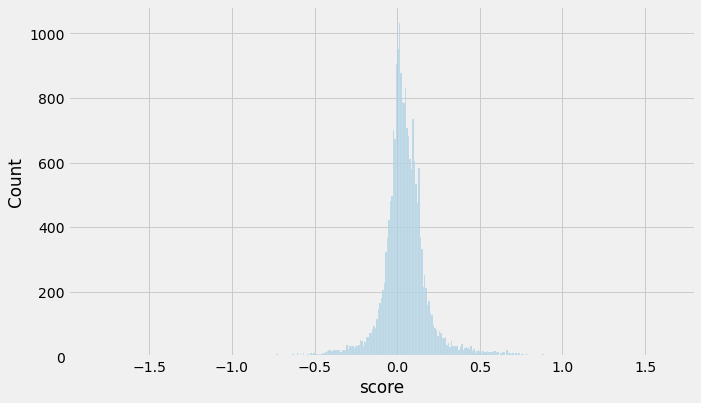

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

Видим много прогнозов меньше 0. Особенность используемого метода

#### Оценка качества

In [47]:
import causalml.metrics as cmetrics

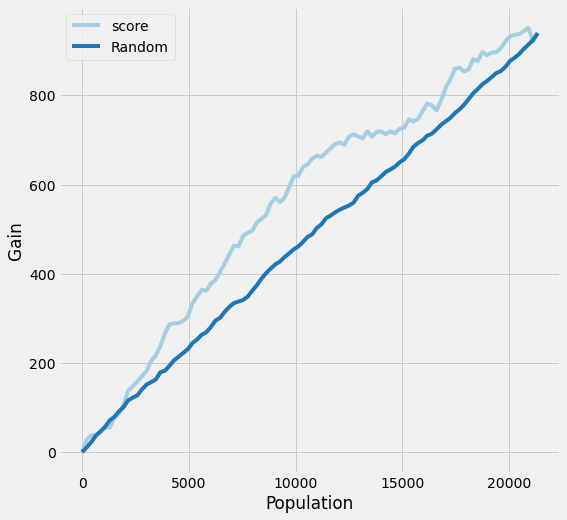

In [48]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

In [49]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=10
)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Uplift curve'}, xlabel='Fraction of data', ylabel='Lift'>

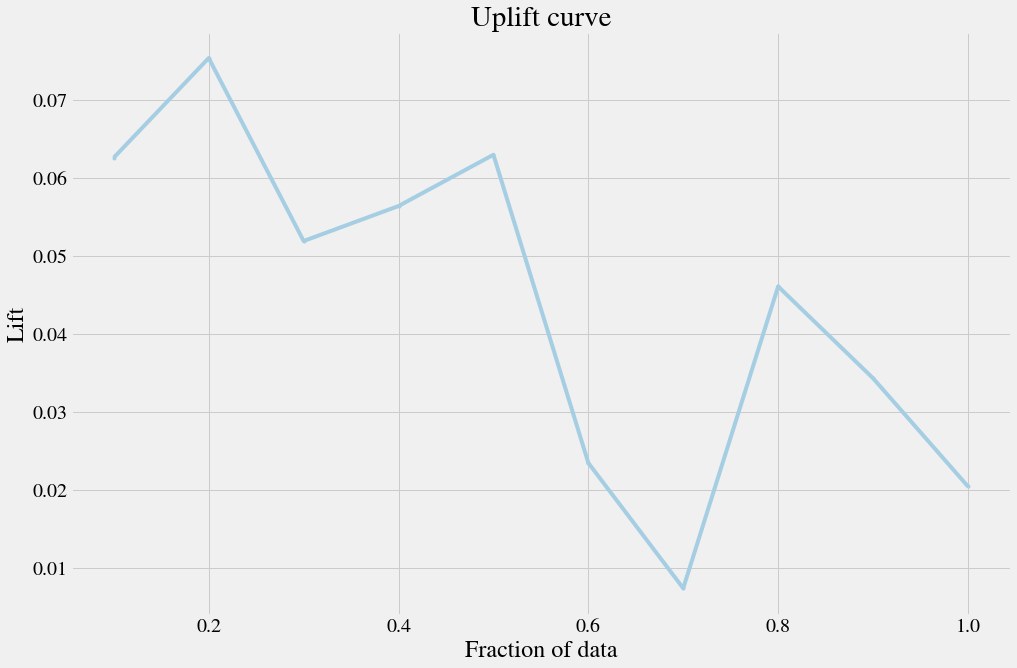

In [50]:
upeval.plot_uplift()

In [52]:
# decile plot

No handles with labels found to put in legend.


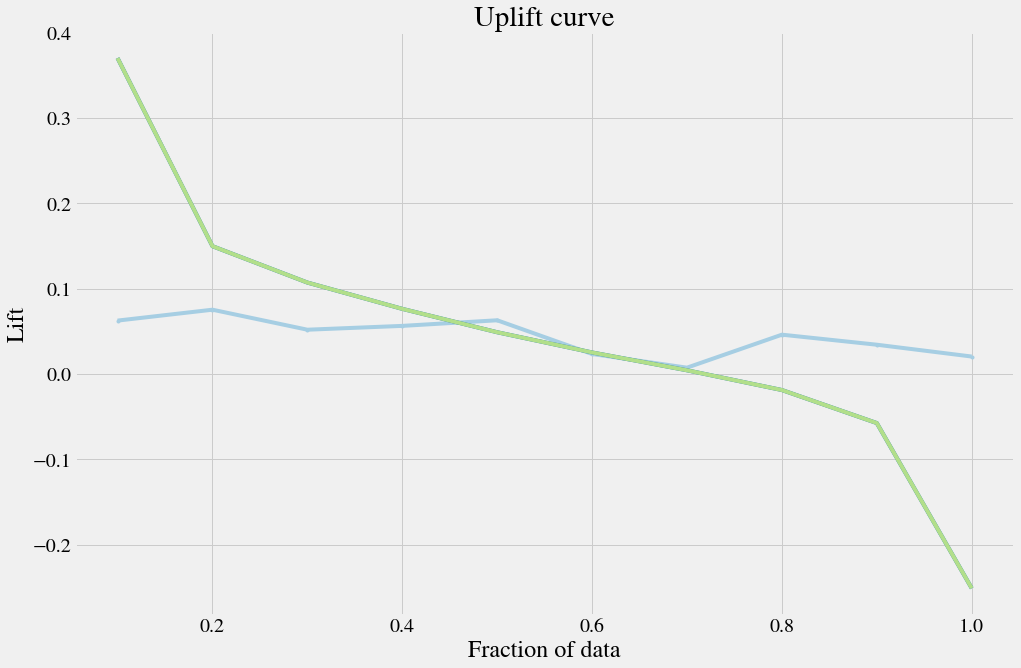

In [53]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))

### Trees

#### Построение модели

In [54]:
from causalml.inference.tree import UpliftRandomForestClassifier

In [55]:
upmodel_rf = UpliftRandomForestClassifier(
    control_name='control',
#     evaluationFunction='CTS',
    n_estimators=10,
    max_depth=4,
    min_samples_leaf=500  # Число должно быть достаточно большим, чтобы аплифту в листьях можно было доверять на предикте
)

In [56]:
upmodel_rf.fit(
    X=data_womens.loc[fit_index, column_set_n1].values,
    treatment=data_womens.loc[fit_index, 'treatment'].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data_womens.loc[fit_index, 'visit'].values
)

In [57]:
eval_data = data_womens.loc[val_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_rf.predict(eval_data[column_set_n1].values)
eval_data = eval_data[['score', 'treatment', 'visit']]

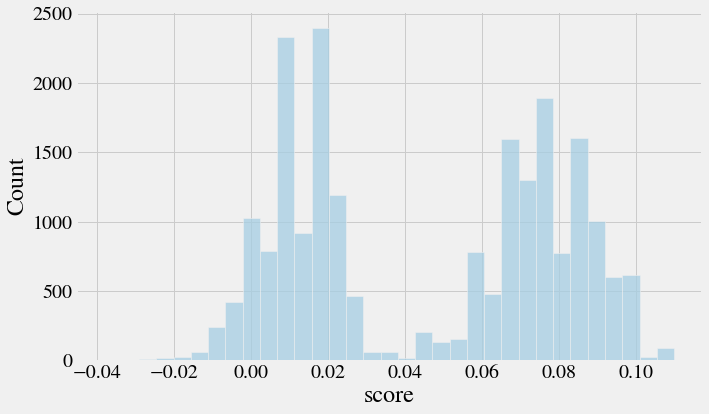

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

#### Оценка качества

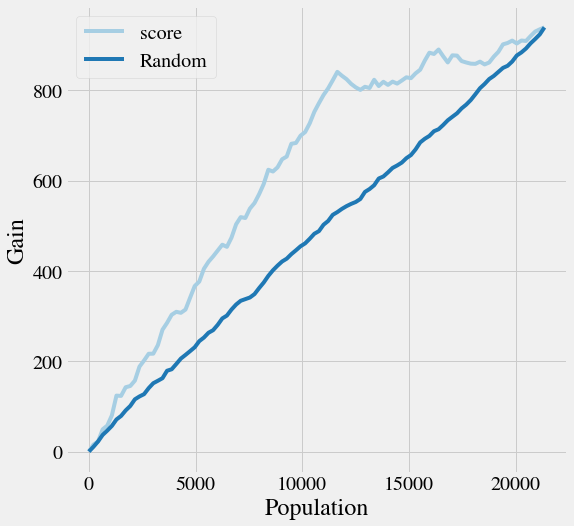

In [59]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

In [60]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=10
)

No handles with labels found to put in legend.


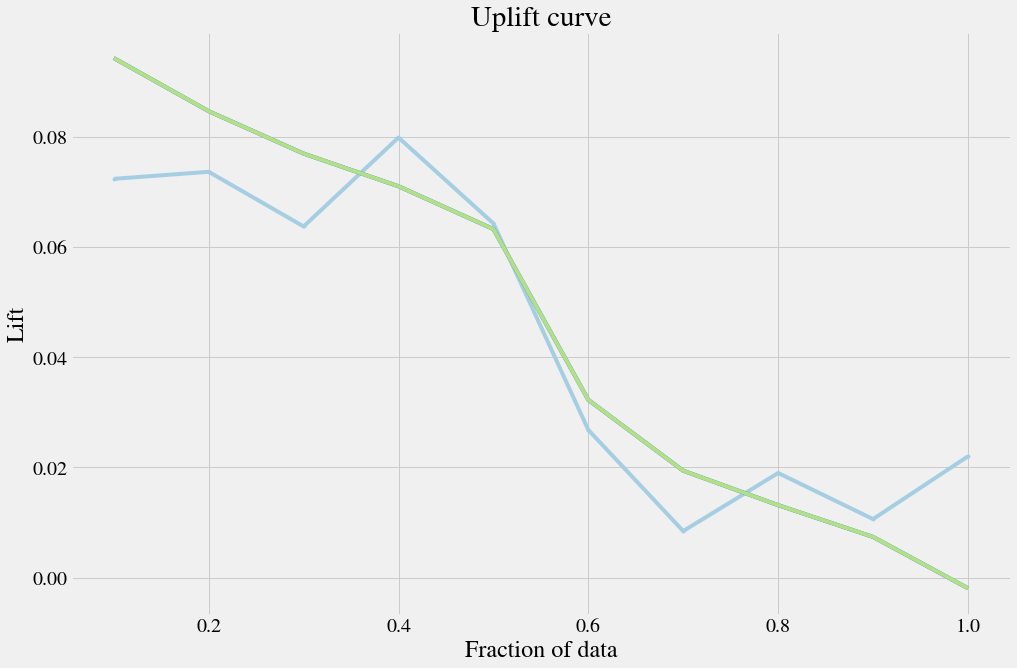

In [61]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))